In [1]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LSTM, TimeDistributed, InputLayer, Reshape, BatchNormalization, Bidirectional

In [2]:
import numpy as np
import pandas as pd
import pickle

def load_dataset(name):
    # x = np.load(f'/datasets/nicolas_facchinetti/processed_data/{name}/x_aug.npy')
    # y = np.load(f'/datasets/nicolas_facchinetti/processed_data/{name}/y_aug.npy')
    # metadata = pd.read_csv(f'/datasets/nicolas_facchinetti/processed_data/{name}/metadata_aug.csv')
    
    data = pickle.load(open(f"D:\\Scuola\\TesiMag\\thesis_adversarial_ml_audio\\processed_data/{name}/processed_data.p", "rb" ))
    x = data['x']
    y = data['y']
    metadata = pd.read_csv(f'D:\\Scuola\\TesiMag\\thesis_adversarial_ml_audio\\processed_data//{name}/metadata_final.csv')
    return x, y, metadata

In [3]:
datasets = ["emodb", "emovo", "ravdess"]
data = {}
for d in datasets:
    x, y, md = load_dataset(d)
    data[d] = {}
    data[d]["x"] = x
    data[d]["y"] = y
    data[d]["metadata"] = md

In [4]:
def leave_one_speaker_out(data, n=5):
    speakers = data.actor.unique()
    # random select n actors as test
    np.random.seed(1997)
    selected = np.random.choice(speakers, size=n, replace=False)
    
    myCViterator = []
    for i in selected:
        # take all but not actor i data
        trainIndices = data[~(data['actor']==i)].index.values.astype(int)
        # take only original samples
        testIndices =  data[(data['actor']==i)].index.values.astype(int)
        
        np.random.shuffle(trainIndices)
        np.random.shuffle(testIndices)
        myCViterator.append((trainIndices, testIndices))
    return myCViterator

In [5]:
import matplotlib.pyplot as plt

def plot_res_acc(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_res_loss(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_stats(h):
    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    for num, c in enumerate(h):
        n = (num+1)*2
        plot_res_acc(c, len(h), n-1)
        plot_res_loss(c, len(h), n)
    plt.show()

In [16]:
def train_avaluate(model_fn, kf, x, y):
    cv_acc = []
    for train_index, val_index in kf:
        m = model_fn()
        m.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
        # fit & predict
        history = m.fit(x[train_index], y[train_index],
                        batch_size=32,
                        epochs=30,
                        validation_data=(x[val_index], y[val_index]),
                        verbose=1)
        print("Done")
        cv_acc.append(history)
    return cv_acc

# Models

In [7]:
def get_m1():
    m = Sequential([
            InputLayer(input_shape=(256,256,3)),
            Reshape((16,16,256,3)),
            TimeDistributed(Conv2D(16, kernel_size=(3,3), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),

            Bidirectional(LSTM(4, return_sequences=False)),
            Dropout(0.6),
            Dense(7, activation='softmax')
    ])
    return m

get_m1().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 16, 16, 256, 3)    0         
_________________________________________________________________
time_distributed (TimeDistri (None, 16, 14, 254, 16)   448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 14, 254, 16)   64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 7, 127, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 5, 125, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 4, 124, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 2, 122, 64)    1

In [8]:
def get_m2():
    m = Sequential([
            InputLayer(input_shape=(256,256,3)),
            Reshape((16,16,256,3)),
            TimeDistributed(Conv2D(16, kernel_size=(3,3), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),

            Bidirectional(LSTM(8, return_sequences=False)),
            Dropout(0.6),
            Dense(7, activation='softmax')
        ])
    return m

get_m2().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 16, 16, 256, 3)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 16, 14, 254, 16)   448       
_________________________________________________________________
time_distributed_9 (TimeDist (None, 16, 14, 254, 16)   64        
_________________________________________________________________
time_distributed_10 (TimeDis (None, 16, 7, 127, 16)    0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 16, 5, 125, 32)    4640      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 16, 4, 124, 32)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 16, 2, 122, 64)   

In [9]:
def get_m3():
    m = Sequential([
            InputLayer(input_shape=(256,256,3)),
            Reshape((16,16,256,3)),
            TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
        
            TimeDistributed(Conv2D(128, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),

            LSTM(4, return_sequences=False),
            Dropout(0.6),
            Dense(7, activation='softmax')
    ])
    return m

get_m3().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 16, 16, 256, 3)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 16, 12, 252, 16)   1216      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 16, 12, 252, 16)   64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 11, 251, 16)   0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 9, 249, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 8, 248, 32)    0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 16, 6, 246, 64)   

In [10]:
def get_m4():
    m = Sequential([
            InputLayer(input_shape=(256,256,3)),
            Reshape((16,16,256,3)),
            TimeDistributed(Conv2D(16, kernel_size=(7,7), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(32, kernel_size=(5,5), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),

            LSTM(4, return_sequences=False),
            Dropout(0.6),
            Dense(7, activation='softmax')
    ])
    return m

get_m4().summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 16, 16, 256, 3)    0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 16, 10, 250, 16)   2368      
_________________________________________________________________
time_distributed_27 (TimeDis (None, 16, 10, 250, 16)   64        
_________________________________________________________________
time_distributed_28 (TimeDis (None, 16, 9, 249, 16)    0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 16, 5, 245, 32)    12832     
_________________________________________________________________
time_distributed_30 (TimeDis (None, 16, 4, 244, 32)    0         
_________________________________________________________________
time_distributed_31 (TimeDis (None, 16, 2, 242, 64)   

In [11]:
def get_m5():
    m = Sequential([
            InputLayer(input_shape=(256,256,3)),
            Reshape((8,32,256,3)),
            TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(5,5), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
        
            TimeDistributed(Conv2D(128, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),

            LSTM(3, return_sequences=False),
            Dropout(0.6),
            Dense(7, activation='softmax')
    ])
    return m

get_m5().summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 8, 32, 256, 3)     0         
_________________________________________________________________
time_distributed_34 (TimeDis (None, 8, 28, 252, 16)    1216      
_________________________________________________________________
time_distributed_35 (TimeDis (None, 8, 28, 252, 16)    64        
_________________________________________________________________
time_distributed_36 (TimeDis (None, 8, 14, 126, 16)    0         
_________________________________________________________________
time_distributed_37 (TimeDis (None, 8, 10, 122, 32)    12832     
_________________________________________________________________
time_distributed_38 (TimeDis (None, 8, 9, 121, 32)     0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 8, 7, 119, 64)    

In [12]:
def get_m6():
    m = Sequential([
            InputLayer(input_shape=(256,256,3)),
            Reshape((8,32,256,3)),
            TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(5,5), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
        
            TimeDistributed(Flatten()),

            Bidirectional(LSTM(3, return_sequences=False)),
            Dropout(0.6),
            Dense(7, activation='softmax')
    ])
    return m

get_m6().summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 8, 32, 256, 3)     0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, 8, 28, 252, 16)    1216      
_________________________________________________________________
time_distributed_45 (TimeDis (None, 8, 28, 252, 16)    64        
_________________________________________________________________
time_distributed_46 (TimeDis (None, 8, 14, 126, 16)    0         
_________________________________________________________________
time_distributed_47 (TimeDis (None, 8, 10, 122, 32)    12832     
_________________________________________________________________
time_distributed_48 (TimeDis (None, 8, 9, 121, 32)     0         
_________________________________________________________________
time_distributed_49 (TimeDis (None, 8, 7, 119, 64)    

In [13]:
def get_m12():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Reshape((9,29,128,1)),
            TimeDistributed(Conv2D(8, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

            TimeDistributed(Conv2D(16, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),
            
            LSTM(1, return_sequences=False, dropout=0.2),
            
            Dense(5, activation='softmax')
    ])
    return m

get_m12().summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed_53 (TimeDis (None, 9, 25, 124, 8)     208       
_________________________________________________________________
time_distributed_54 (TimeDis (None, 9, 25, 124, 8)     32        
_________________________________________________________________
time_distributed_55 (TimeDis (None, 9, 12, 62, 8)      0         
_________________________________________________________________
time_distributed_56 (TimeDis (None, 9, 10, 60, 16)     1168      
_________________________________________________________________
time_distributed_57 (TimeDis (None, 9, 9, 59, 16)      0         
_________________________________________________________________
time_distributed_58 (TimeDis (None, 9, 8496)          

# EmoDB

In [14]:
kf1 = leave_one_speaker_out(data["emodb"]["metadata"], n=3)         

In [17]:
ac1_1 = train_avaluate(get_m12, kf1, data["emodb"]["x"], data["emodb"]["y"] )

Epoch 1/30
122/122 [==============================] - 16s 106ms/step - loss: 1.6076 - accuracy: 0.2338 - val_loss: 1.6040 - val_accuracy: 0.2784
Epoch 2/30
122/122 [==============================] - 14s 113ms/step - loss: 1.6043 - accuracy: 0.2377 - val_loss: 1.5892 - val_accuracy: 0.2784
Epoch 3/30
122/122 [==============================] - 20s 163ms/step - loss: 1.6022 - accuracy: 0.2441 - val_loss: 1.5986 - val_accuracy: 0.2784
Epoch 4/30
122/122 [==============================] - 17s 136ms/step - loss: 1.6016 - accuracy: 0.2441 - val_loss: 1.5977 - val_accuracy: 0.2784
Epoch 5/30
122/122 [==============================] - 17s 141ms/step - loss: 1.5951 - accuracy: 0.2441 - val_loss: 1.6134 - val_accuracy: 0.1538
Epoch 6/30
122/122 [==============================] - 14s 113ms/step - loss: 1.4427 - accuracy: 0.3775 - val_loss: 1.5393 - val_accuracy: 0.3370
Epoch 7/30
122/122 [==============================] - 16s 129ms/step - loss: 1.3461 - accuracy: 0.3863 - val_loss: 1.3693 - val_ac

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
plot_stats(ac1_1)

# EMOVO

In [18]:
kf2 = leave_one_speaker_out(data["emovo"]["metadata"], n=3)    

In [19]:
ac2_1 = train_avaluate(get_m12, kf2, data["emovo"]["x"], data["emovo"]["y"])

Epoch 1/30
128/128 [==============================] - 16s 106ms/step - loss: 1.6095 - accuracy: 0.2017 - val_loss: nan - val_accuracy: 0.2181
Epoch 2/30
128/128 [==============================] - 13s 99ms/step - loss: 1.5734 - accuracy: 0.2402 - val_loss: nan - val_accuracy: 0.2591
Epoch 3/30
128/128 [==============================] - 13s 98ms/step - loss: 1.4846 - accuracy: 0.3060 - val_loss: nan - val_accuracy: 0.2298
Epoch 4/30
128/128 [==============================] - 13s 99ms/step - loss: 1.4334 - accuracy: 0.3583 - val_loss: nan - val_accuracy: 0.2181
Epoch 5/30
128/128 [==============================] - 13s 100ms/step - loss: 1.3932 - accuracy: 0.3710 - val_loss: nan - val_accuracy: 0.2251
Epoch 6/30
128/128 [==============================] - 16s 127ms/step - loss: 1.3722 - accuracy: 0.3747 - val_loss: nan - val_accuracy: 0.3435
Epoch 7/30
128/128 [==============================] - 17s 129ms/step - loss: 1.3400 - accuracy: 0.3809 - val_loss: nan - val_accuracy: 0.3763
Epoch 8/3

Epoch 26/30
130/130 [==============================] - 18s 138ms/step - loss: nan - accuracy: 0.1864 - val_loss: nan - val_accuracy: 0.2173
Epoch 27/30
130/130 [==============================] - 16s 126ms/step - loss: nan - accuracy: 0.1864 - val_loss: nan - val_accuracy: 0.2173
Epoch 28/30
130/130 [==============================] - 16s 121ms/step - loss: nan - accuracy: 0.1864 - val_loss: nan - val_accuracy: 0.2173
Epoch 29/30
130/130 [==============================] - 18s 140ms/step - loss: nan - accuracy: 0.1864 - val_loss: nan - val_accuracy: 0.2173oss: nan - accuracy:  - ETA: 16s - loss: nan - accuracy - ETA: 15s - loss: nan - accuracy:  - 
Epoch 30/30
130/130 [==============================] - 17s 130ms/step - loss: nan - accuracy: 0.1864 - val_loss: nan - val_accuracy: 0.2173
Done
Epoch 1/30
124/124 [==============================] - 20s 122ms/step - loss: nan - accuracy: 0.1991 - val_loss: nan - val_accuracy: 0.1874
Epoch 2/30
124/124 [==============================] - 15s 121m

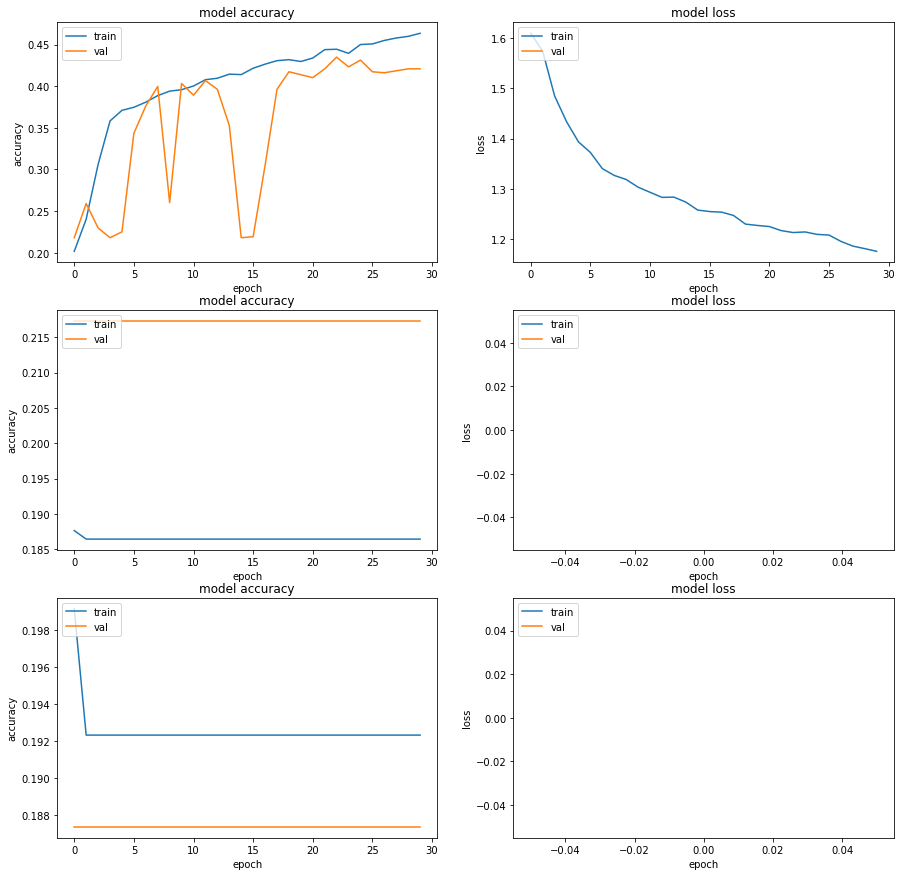

In [20]:
plot_stats(ac2_1)

# RAVDESS

In [21]:
kf3 = leave_one_speaker_out(data["ravdess"]["metadata"], n=3)    

In [22]:
ac3_1 = train_avaluate(get_m12, kf3, data["ravdess"]["x"], data["ravdess"]["y"])

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
plot_stats(ac3_1)